In [1]:
import os
from Bio import SeqIO
import numpy as np
import pandas as pd
import os
aminoacids='ARNDCQEGHILKMFPSTWYV-'


aaindex=pd.read_table('aaindex31.txt',sep='\s+',header=None)
aaindex=aaindex.subtract(aaindex.min(axis=1),axis=0).divide((aaindex.max(axis=1)-aaindex.min(axis=1)),axis=0)
aa=[x for x in 'ARNDCQEGHILKMFPSTWYV']
aaindex=aaindex.to_numpy().T
index={x:y for x,y in zip(aa,aaindex.tolist())}
index['-']=np.zeros(31).tolist()
index['X']=np.zeros(31).tolist()

def index_encode(Sequence_one_hot_encoding):
    encoding=[]
    for i in range(len(Sequence_one_hot_encoding)):
        s=Sequence_one_hot_encoding[i]
        encoding.append([index[x] for x in (s)])
    encoding=np.array(encoding)
    return encoding


def binary_encode(Sequence_one_hot_encoding):        
    aa2v={x:y for x,y in zip(aminoacids,np.eye(21,21).tolist())}
    aa2v['X']=np.zeros(21)
    encoding=[]
    for i in range(len(Sequence_one_hot_encoding)):
        s=Sequence_one_hot_encoding[i]
        encoding.append([aa2v[x] for x in (s)])
    encoding=np.array(encoding)
    return encoding
   

seed = 321
cut_off = int(16)
r_test_x = []
r_test_y = []
alphabet = 'ARNDCQEGHILKMFPSTWYV-'

char_to_int = dict((c,i) for i, c in enumerate(alphabet))
int_to_char = dict((i,c) for i, c in enumerate(alphabet))
#for positive sequence
def innertest1():
    #Input
    sequence = str(seq_record.seq)
    sequence = sequence[cut_off:-cut_off]
    for char in sequence:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in sequence]
    r_test_x.append(integer_encoded)
    r_test_y.append(1)
for seq_record in SeqIO.parse("Ubiquitylation_81_window_Testing_positive.fasta", "fasta"):
    innertest1()
#for negative sequence
def innertest2():
    #Input
    sequence = str(seq_record.seq)
    sequence = sequence[cut_off:-cut_off]
    for char in sequence:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in sequence]
    r_test_x.append(integer_encoded)
    r_test_y.append(0)
for seq_record in SeqIO.parse("Ubiquitylation_81_window_Testing_negative.fasta", "fasta"):
    innertest2()


# Changing to array (matrix)    
r_test_x_embedding = np.array(r_test_x)
r_test_y_embedding = np.array(r_test_y)


r_test_x = []
r_test_y = []
#for positive sequence
def innertest1():
    #Input
    sequence = str(seq_record.seq)
    sequence = sequence[cut_off:-cut_off]
    for char in sequence:
        if char not in alphabet:
            return
    r_test_x.append(sequence)
    r_test_y.append(1)
for seq_record in SeqIO.parse("Ubiquitylation_81_window_Testing_positive.fasta", "fasta"):
    innertest1()
#for negative sequence
def innertest2():
    #Input
    sequence = str(seq_record.seq)
    sequence = sequence[cut_off:-cut_off]
    for char in sequence:
        if char not in alphabet:
            return
    r_test_x.append(sequence)
    r_test_y.append(0)
for seq_record in SeqIO.parse("Ubiquitylation_81_window_Testing_negative.fasta", "fasta"):
    innertest2()

binaryCoding_Independent_Test = binary_encode(r_test_x)  

AA_Independent_Test = index_encode(r_test_x)

y_independent = np.array(r_test_y)

In [2]:
binaryCoding_Independent_Test.shape

(6805, 49, 21)

In [3]:
AA_Independent_Test.shape

(6805, 49, 31)

In [4]:
r_test_x_embedding.shape

(6805, 49)

# Load the Model

In [5]:
from tensorflow import keras
model = keras.models.load_model("DeepUBImodel_HubiPred_AAindex_One_Hot_Emb_drop_out_changed73887.h5")

In [6]:
Y_pred = model.predict([AA_Independent_Test,binaryCoding_Independent_Test,r_test_x_embedding])

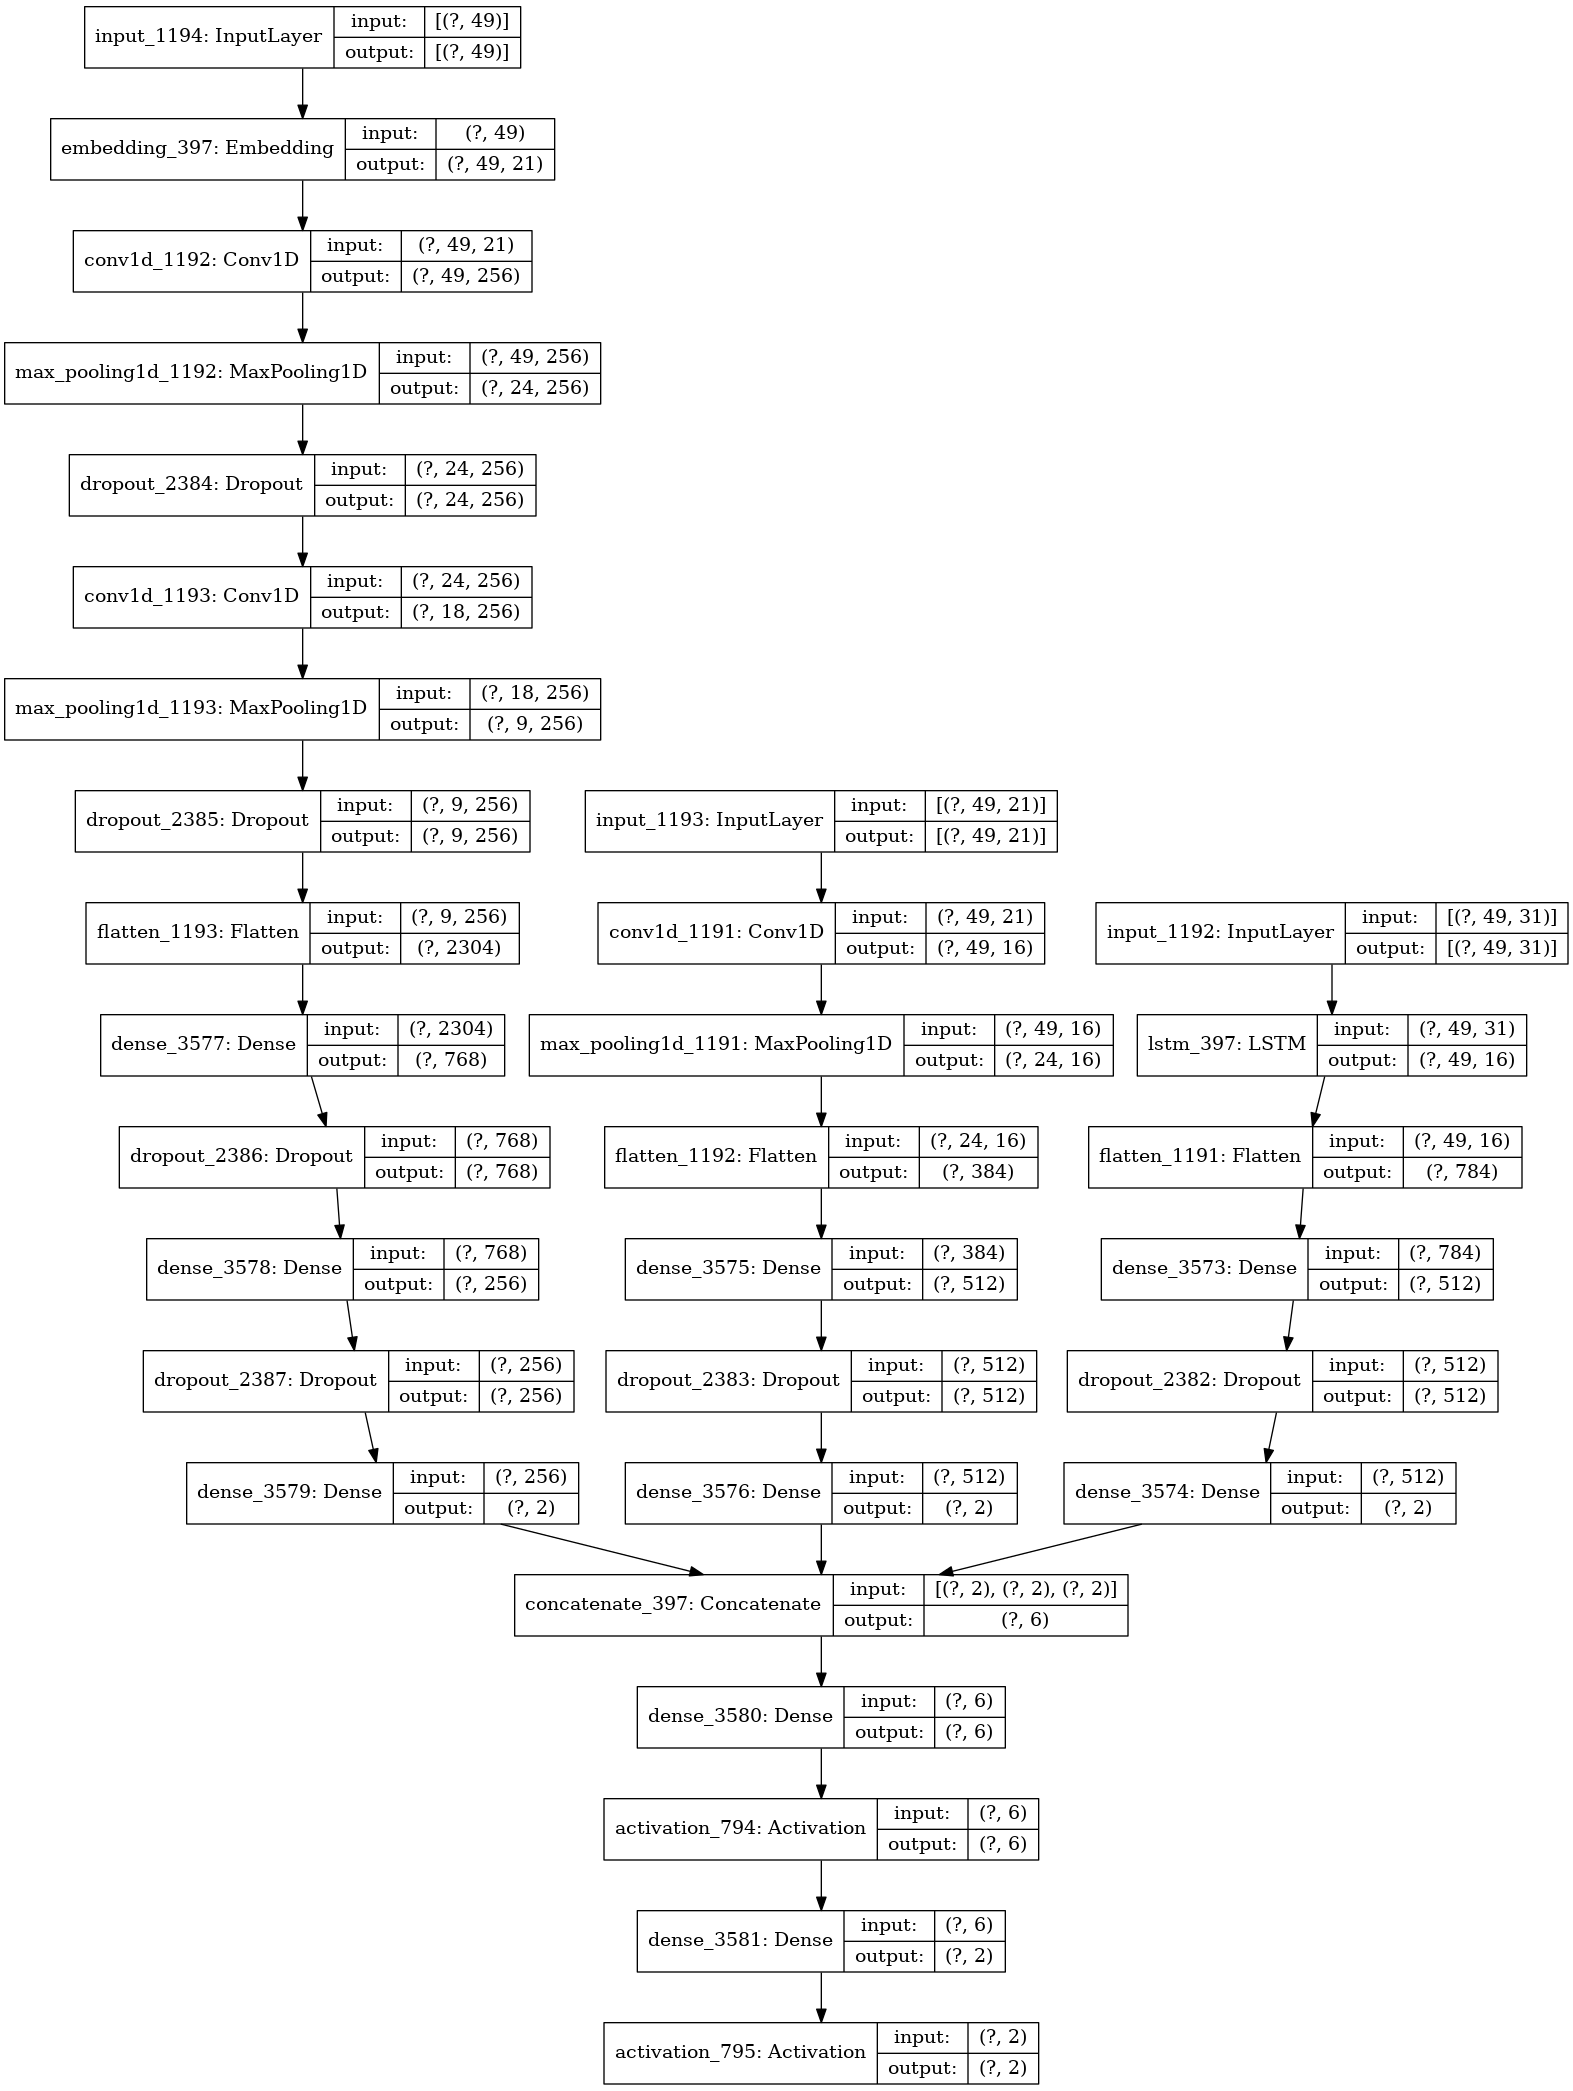

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes = True, to_file='Human_Ubiquitination.png')

In [8]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
yval = y_independent
t_pred2 = Y_pred[:,1]

Y_pred = (Y_pred > 0.5)
y_pred1 = [np.argmax(y, axis=None, out=None) for y in Y_pred]
y_pred1 = np.array(y_pred1)


mcc_test = matthews_corrcoef(yval, y_pred1)
# For sensitivity and specificity
sp_1, sn_1 = confusion_matrix(yval, y_pred1)
sp_2_test = sp_1[0]/(sp_1[0]+sp_1[1])
sn_2_test = sn_1[1]/(sn_1[0]+sn_1[1])
# ROC


print("Specificity = ",sp_2_test, " Sensitivity = ",sn_2_test)
print(model.summary())
print("testx",yval.shape)

y_pred = y_pred1



Specificity =  0.7139076742134667  Sensitivity =  0.8040540540540541
Model: "functional_795"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1194 (InputLayer)         [(None, 49)]         0                                            
__________________________________________________________________________________________________
embedding_397 (Embedding)       (None, 49, 21)       483         input_1194[0][0]                 
__________________________________________________________________________________________________
conv1d_1192 (Conv1D)            (None, 49, 256)      5632        embedding_397[0][0]              
__________________________________________________________________________________________________
max_pooling1d_1192 (MaxPooling1 (None, 24, 256)      0           conv1d_1192[0][0]                
________________

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score,matthews_corrcoef
Accuracyyyyy = accuracy_score(yval, y_pred)
cm = confusion_matrix(yval, y_pred)
mcc = matthews_corrcoef(yval, y_pred)

print("Matthews Correlation : ",mcc)
print("\n")
print("Confusion Matrix : \n",cm)
print("\n")
print("Accuracy on test set:   ",Accuracyyyyy)
print("\n")

TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]

Sensitivity = TP/(TP+FN)

Specificity = TN/(TN+FP)


print("Sensitivity:   ",Sensitivity,"\t","Specificity:   ",Specificity)

print(classification_report(yval, y_pred))

Matthews Correlation :  0.5200899736544208


Confusion Matrix : 
 [[2428  973]
 [ 667 2737]]


Accuracy on test set:    0.7590007347538574


Sensitivity:    0.8040540540540541 	 Specificity:    0.7139076742134667
              precision    recall  f1-score   support

           0       0.78      0.71      0.75      3401
           1       0.74      0.80      0.77      3404

    accuracy                           0.76      6805
   macro avg       0.76      0.76      0.76      6805
weighted avg       0.76      0.76      0.76      6805



# Thank You